Code for recording wav file:

In [15]:
import sounddevice as sd
from scipy.io.wavfile import write

fs = 44100
seconds = 5  
print("recording")
myrecording = sd.rec(int(seconds * fs), samplerate=fs, channels=2)
sd.wait()  
write('speech/output.wav', fs, myrecording) 

recording


In [146]:
%matplotlib inline

import os

import IPython
import matplotlib
import matplotlib.pyplot as plt
import requests
import torch
import torchaudio

matplotlib.rcParams["figure.figsize"] = [16.0, 4.8]

torch.random.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(torch.__version__)
print(torchaudio.__version__)
print(device)

SPEECH_FILE = "speech/output.wav"


1.13.0+cu117
0.13.0+cu117
cuda


The class that generates transcripts

In [154]:
class GreedyCTCDecoder(torch.nn.Module):
    def __init__(self, labels, blank=0):
        super().__init__()
        self.labels = labels
        self.blank = blank

    def forward(self, emission: torch.Tensor) -> str:
        """Given a sequence emission over labels, get the best path string
        Args:
          emission (Tensor): Logit tensors. Shape `[num_seq, num_label]`.

        Returns:
          str: The resulting transcript
        """
        indices = torch.argmax(emission, dim=-1)  # [num_seq,]
        indices = torch.unique_consecutive(indices, dim=-1)
        indices = [i for i in indices if i != self.blank]
        return "".join([self.labels[i] for i in indices])

We will create a Wav2Vec2 model that performs the feature
extraction and the classification. It uses the pre-trained weights from torchaudio.




In [147]:
bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H
model = bundle.get_model().to(device)



We load the recorded file:




In [148]:
IPython.display.Audio(SPEECH_FILE)

ValueError: rate must be specified when data is a numpy array or list of audio samples.

In [186]:
SPEECH_FILE = "speech/output.wav"
RECORDING=True
if RECORDING:
    print("recording")
    myrecording = sd.rec(int(seconds * fs), samplerate=fs, channels=2)
    sd.wait()  
    write(SPEECH_FILE, fs, myrecording) 

recording


In [187]:
waveform, sample_rate = torchaudio.load(SPEECH_FILE)
waveform = waveform.to(device)

if sample_rate != bundle.sample_rate:
    waveform = torchaudio.functional.resample(waveform, sample_rate, bundle.sample_rate)

Extracting acoustic features
 


In [188]:
with torch.inference_mode():
    features, _ = model.extract_features(waveform)


Feature classification






In [189]:
with torch.inference_mode():
    emission, _ = model(waveform)



Let’s visualize the output.




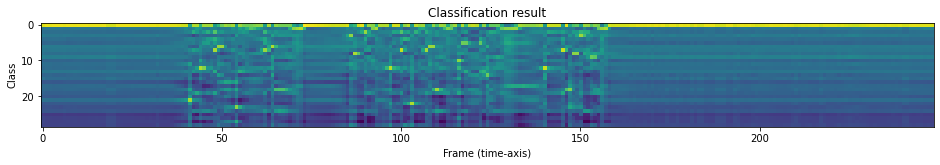

Class labels: ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


In [190]:
plt.imshow(emission[0].cpu().T)
plt.title("Classification result")
plt.xlabel("Frame (time-axis)")
plt.ylabel("Class")
plt.show()
print("Class labels:", bundle.get_labels())

Generating transcripts




In [191]:
decoder = GreedyCTCDecoder(labels=bundle.get_labels())
transcript = decoder(emission[0])
print(transcript)
IPython.display.Audio(SPEECH_FILE)

BLINKIN|THE|LIVING|ROOM|LIGHTS|


Creating the iot object

In [192]:
from command_matcher import connected_object,objects_network,match_semantic


OBJECTS = "light window door".split()
ATTRIBUTES = "red blue green bedroom livingroom kitchen".split()
ACTIONS = "turn off on close open raise start stop blink".split()


light_1=connected_object('light')
light_1.set_attribute('kitchen')
light_1.set_action('turnoff',lambda :print("turnoff kitchen light"))
light_1.set_action('turnon',lambda :print("turnon kitchen light"))
light_1.set_action('blink',lambda :print("blink kitchen light"))

light_2=connected_object('light')
light_2.set_attribute('bedroom')
light_2.set_action('turnoff',lambda :print("turning off bedroom light"))
light_2.set_action('turnon',lambda :print("turning on bedroom light"))
light_2.set_action('blink',lambda :print("blinking bedroom light"))

light_3=connected_object('light')
light_3.set_attribute('livingroom')
light_3.set_action('turnoff',lambda :print("turning off livingroom light"))
light_3.set_action('turnon',lambda :print("turning on livingroom light"))
light_3.set_action('blink',lambda :print("blinking livingroom light"))


door=connected_object('door')
door.set_action('close',lambda :print("closing the door"))
door.set_action('open',lambda :print("opening the door"))


window=connected_object('window')
window.set_action('close',lambda :print("closing the window"))
window.set_action('open',lambda :print("opening the window"))

home_network=objects_network(OBJECTS,ATTRIBUTES,ACTIONS)

home_network.add_obj(light_1)
home_network.add_obj(light_2)
home_network.add_obj(light_3)
home_network.add_obj(window)
home_network.add_obj(door)

In [193]:
sentence=transcript.replace('|',' ').lower()
home_network.trigger_object(
    match_semantic(OBJECTS,sentence),
    match_semantic(ATTRIBUTES,sentence),
    match_semantic(ACTIONS,sentence))

blinking livingroom light


True